In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

import sys
BASE_PATH = pathlib.Path('..')
sys.path.append(BASE_PATH.name)

import common.loss_utils as loss_utils
import common.utils as utils
import common.checkpointing as checkpointing

sys.path.append('./dgmr-oneshot')
import dgmr

/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16
FOLDER = pathlib.Path('weights/dgmr_oneshot')

In [7]:
p = BASE_PATH / 'data/train.npz'
f = np.load(p)
times = f['times']
data = f['data']

In [ ]:
times.shape, data.shape

In [9]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [10]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [11]:
x, y = ds[0]

In [12]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

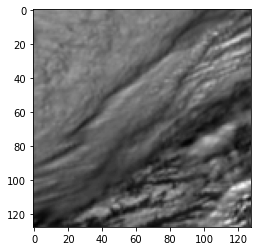

In [13]:
plt.imshow(x[-1], cmap='gray')

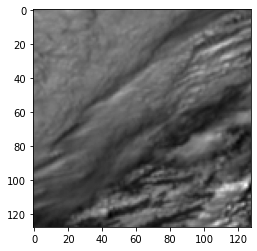

In [14]:
plt.imshow(y[0], cmap='gray')

In [19]:
# initialize the model and load weights from checkpoint, if applicable

chptr = checkpointing.Checkpointer(FOLDER)

checkpoint, best_epoch = chptr.load_checkpoint()

ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=160,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=96,
    context_channels=160,
    output_channels=1,
)

model = dgmr.generators.Generator(ccs, sampler)
if checkpoint is not None:
    print(f'Loading model epoch {best_epoch}')
    model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)

print(f'The model has {utils.count_parameters(model)} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if checkpoint is not None:
    print(f'Loading optimizer {best_epoch}')
    optimizer.load_state_dict(checkpoint['optimizer'])

msssim_criterion = loss_utils.MS_SSIMLoss(1023.0, channels=24)

# holding this in memory now is a waste
if checkpoint is not None:
    del checkpoint
    torch.cuda.empty_cache()


The model has 235695682 trainable parameters


In [20]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)
        preds = model(x)
        y = y * _STD_PIXEL + _MEAN_PIXEL
        preds = preds * _STD_PIXEL + _MEAN_PIXEL
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
    return epoch_loss / total_count



In [ ]:
EPOCHS = 100
EXISTING = best_epoch + 1 if best_epoch is not None else 1

for i in range(EXISTING, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, msssim_criterion)
    avg_loss = round(avg_loss, 4)
    chptr.save_checkpoint(model, optimizer, i, avg_loss)
